# About

This is an experiment to look at how good the SPICE models are compared to the graphs one get from a component's datasheet.

For this setup I've first used [WebPlotDigitizer](https://automeris.io/WebPlotDigitizer/) to convert a picture of the "Output characteristic" curve to a CSV file (`plots/wpd_datasets.csv`). After that I've taken the SPICE model and used it with LTSpice to generate similar curves.

> Note: I've previously found a tool that can extract similar plots but also give a high-degree polynomial that fits the curve very tighly. This would be even better (and faster!) than my manual process.

The component used in this setup is [DMP3056L](https://www.diodes.com/products/discrete/mosfets/mosfet-master-table/p-channel/p-channel-30v/part/DMP3056L) ([Datasheet](https://www.diodes.com/assets/Datasheets/DMP3056L.pdf), [SPICE model](https://www.diodes.com/spice/download/3435/DMP3056L.spice.txt)) from Diodes Inc.

If you just want the comparison, scroll to the bottom!.

In [1]:
import ee
import pandas
import matplotlib.pyplot as plt
%matplotlib notebook
#%matplotlib inline

%reload_ext ee

#### Configure matplotlib

Just to make the plots a bit bigger and have a useful font size.

In [2]:
font = {'size'   : 22}
plt.rc('font', **font)
fig_size = [12, 8]
plt.rcParams["figure.figsize"] = fig_size

In [3]:
# The different Vgs values we have from the datasheet and the simulation
vgs_list = "-2.5", "-3.0", "-4.0", "-4.5", "-10.0"

# The highest Id we have, mainly to make the plots have the same scales.
id_max = 12
vds_max = 5

# From data sheet

This is the input picture that was used with WebPlotDigitizer:

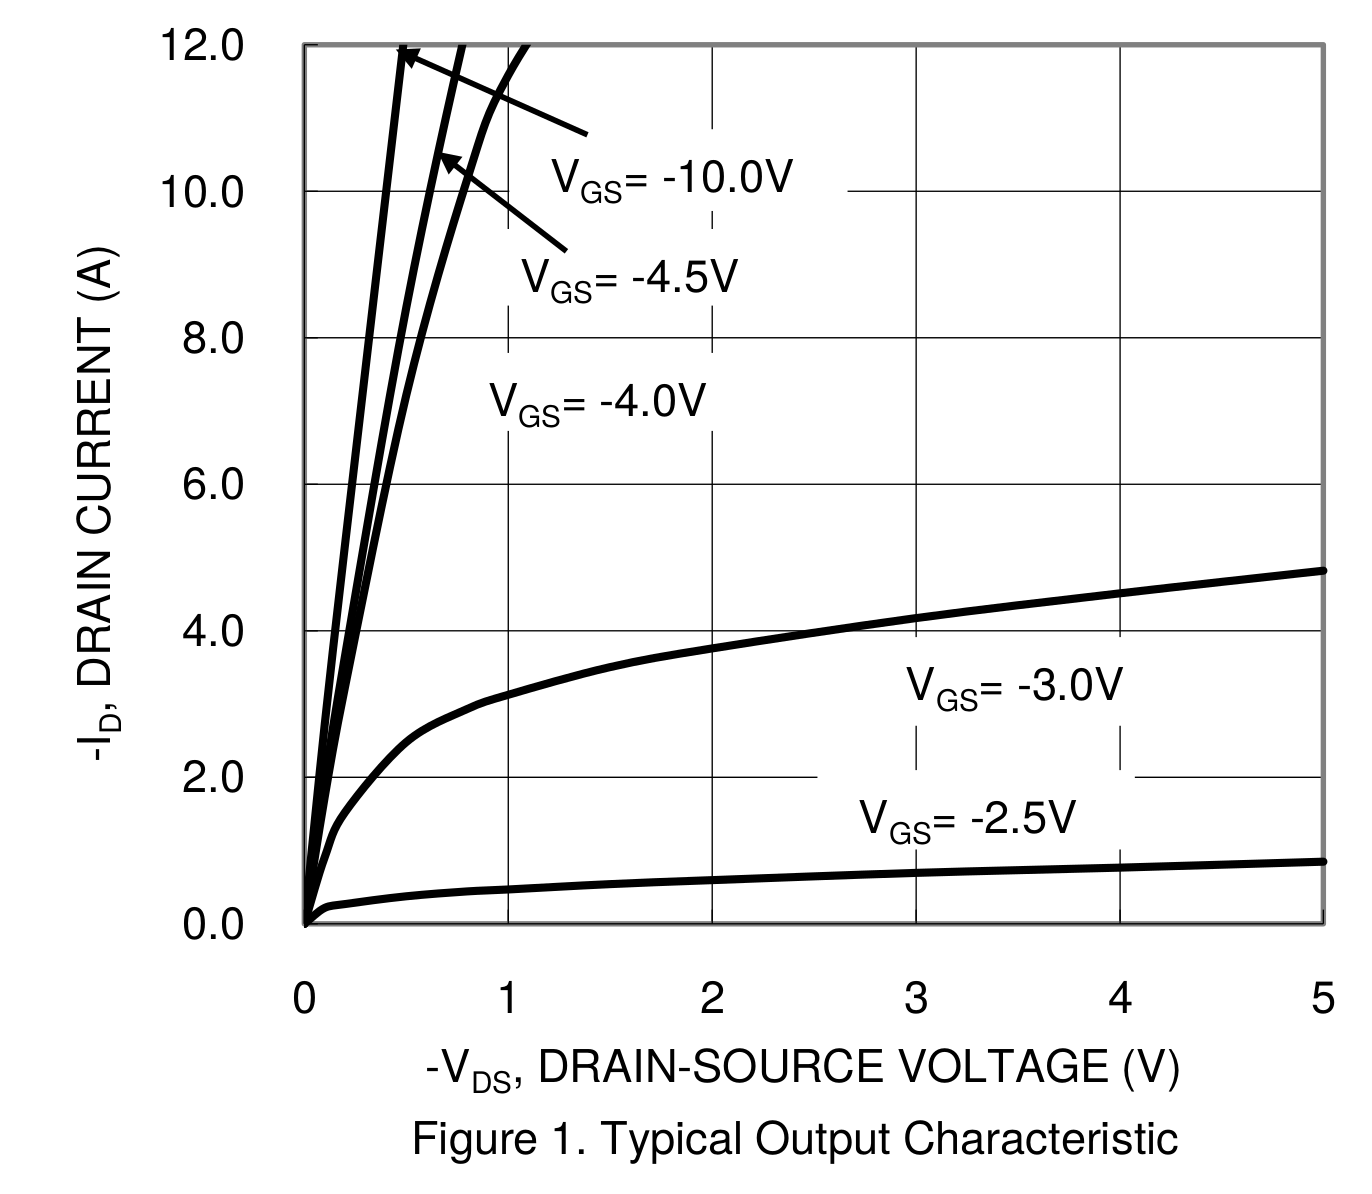

In [4]:
df = pandas.\
    read_csv("plots/wpd_datasets.csv", skiprows=[1]).\
    rename(index=str, columns={
        "Vgs=-2.5V": "Vds@Vgs=-2.5V",
        "Unnamed: 1": "Id@Vgs=-2.5V",
        "Vgs=-3.0V": "Vds@Vgs=-3.0V",
        "Unnamed: 3": "Id@Vgs=-3.0V",
        "Vgs=-4.0V": "Vds@Vgs=-4.0V",
        "Unnamed: 5": "Id@Vgs=-4.0V",
        "Vgs=-4.5V": "Vds@Vgs=-4.5V",
        "Unnamed: 7": "Id@Vgs=-4.5V",
        "Vgs=-10.0V": "Vds@Vgs=-10.0V",
        "Unnamed: 9": "Id@Vgs=-10.0V",
})

In [5]:
ds_values = {}
for vgs_str in vgs_list:
    vds_str = "Vds@Vgs={}V".format(vgs_str)
    id_str = "Id@Vgs={}V".format(vgs_str)
    selection = df[df[vds_str].notna()][[vds_str, id_str]].\
        rename(index=str, columns={vds_str: "Vds", id_str: "Id"})
    # the points that where manually added comes last in the CSV file
    selection = selection.sort_values(by=['Vds'])
    ds_values[vgs_str] = selection

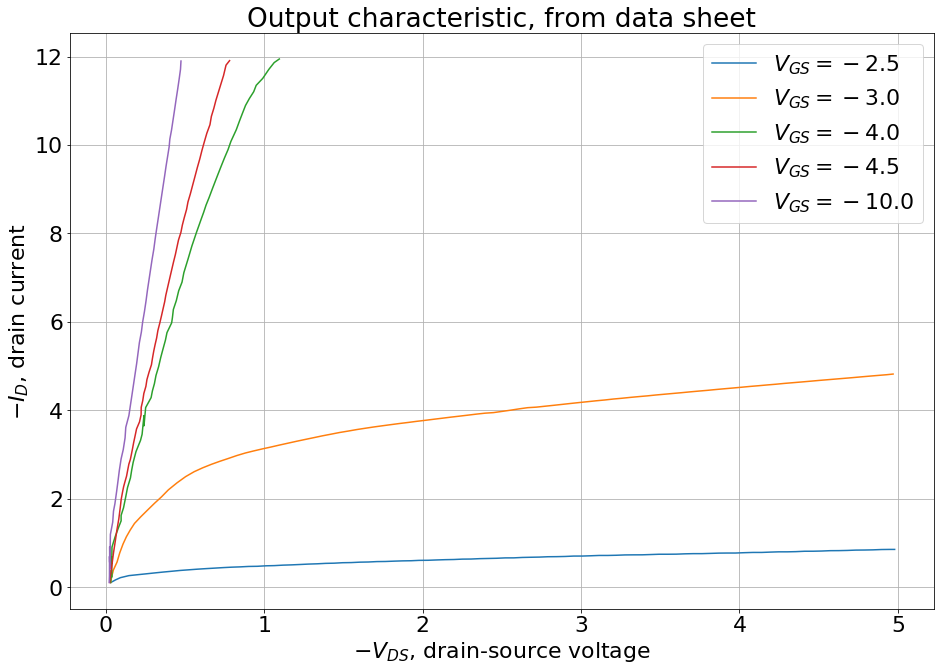

In [6]:
fig = plt.figure()

ax = fig.add_axes([0, 0, 1, 1])
ax.set_title("Output characteristic, from data sheet")
ax.set_ylabel("$-I_D$, drain current")
ax.set_xlabel("$-V_{DS}$, drain-source voltage")

for (vgs, ds) in ds_values.items():
    plt.plot(ds["Vds"], ds["Id"], label="$V_{{GS}}={}$".format(vgs))
plt.legend()
plt.grid()

None

# SPICE data

 For future reference, this is how I converted the LTSpice exported EMF file to PNG: https://askubuntu.com/a/710799. Then I used imagemagick to crop lots of extra white space:

    libreoffice --headless --convert-to png DMP3056L-test.emf
    convert -trim DMP3056L-test.png  DMP3056L-test2.png
    mv DMP3056L-test2.png DMP3056L-test.png
    
## SPICE schematic

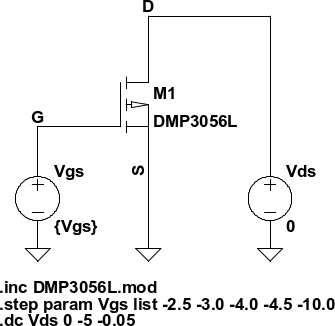

My own tools for parsing the raw file (LTSpice's output file) is parsed with my own [`ee` library for Python](https://trygvis.io/git/2017/07/ee-python.git/).

In [7]:
raw = ee.read_ltspice_raw("DMP3056L-test.raw")

### Variables

In [8]:
pandas.DataFrame(columns=["Variable", "kind"], data=[[v.expression, v.kind] for v in raw.variables])

,Variable,kind
0,vds,voltage
1,V(d),voltage
2,V(g),voltage
3,I(Vgs),device_current
4,I(Vds),device_current
5,Ix(m1:10),subckt_current
6,Ix(m1:20),subckt_current
7,Ix(m1:30),subckt_current


In [9]:
df=raw.to_pandas().rename(index=str, columns={"V(g)": "Vg", "vds": "Vds", "I(Vds)":"Id"})

df[["Vg"]]=df[["Vg"]].astype(str)

sim_values = {}
for vgs in vgs_list:
    values = df[(df["Vg"] == vgs) & (df["Id"] <= id_max)][["Vds", "Id"]]
    values[["Vds"]] = -values[["Vds"]]
#    values[["Id"]] = values[["Id"]]
    sim_values[vgs] = values

#sim_values["-10.0"]

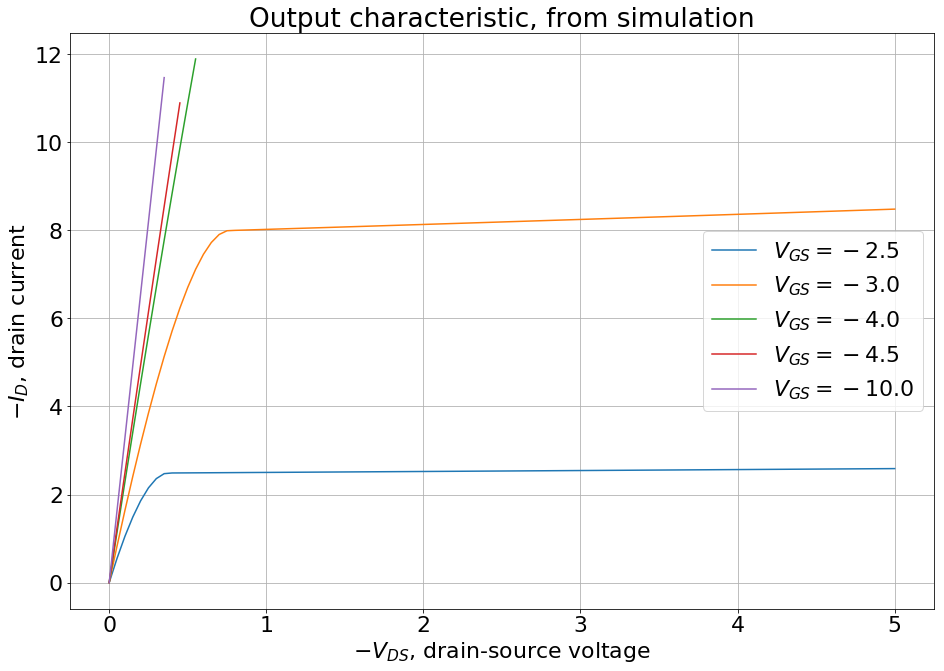

In [10]:
fig = plt.figure()

ax = fig.add_axes([0, 0, 1, 1])
ax.set_title("Output characteristic, from simulation")
ax.set_ylabel("$-I_D$, drain current")
ax.set_xlabel("$-V_{DS}$, drain-source voltage")

for (vgs, ds) in sim_values.items():
    plt.plot(ds["Vds"], ds["Id"], label="$V_{{GS}}={}$".format(vgs))
plt.legend()
plt.grid()

None

# Combined

In [11]:
# These didn't turn out too useful.
if False:
    for vgs in vgs_list: #[vgs_list[0]]:
        sim, ds = (sim_values[vgs], ds_values[vgs])
        fig = plt.figure()

        ax = fig.add_axes([0, 0, 1, 1])
        ax.set_title("Output characteristic, $-V_{{GS}}={}$".format(vgs))
        ax.set_ylabel("$-I_D$, drain current")
        ax.set_xlabel("$-V_{DS}$, drain-source voltage")

        plt.plot(sim["Vds"], sim["Id"], label="simulated")
        plt.plot(ds["Vds"], ds["Id"], label="datasheet")
        plt.legend()
        plt.grid()
        plt.ylim(0, id_max)
        plt.xlim(0, vds_max)

None

<Figure size 864x576 with 0 Axes>

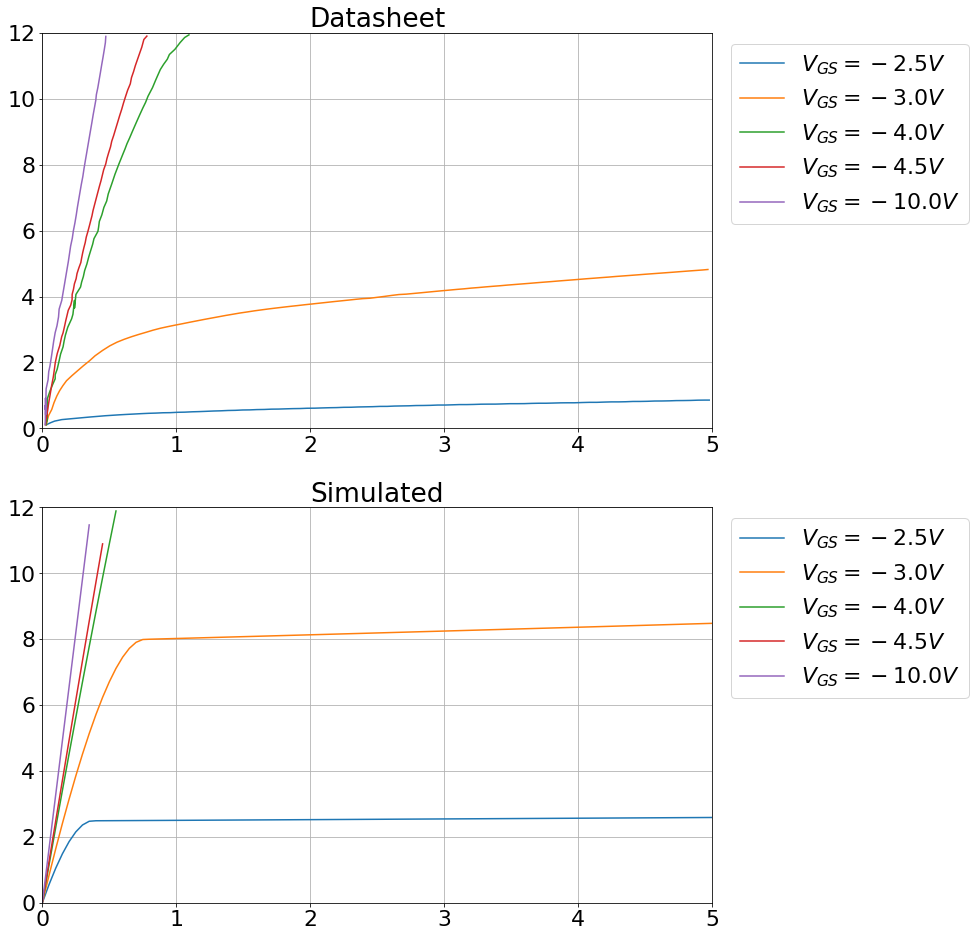

In [12]:
plt.figure()

fig, (ds_plt, sim_plt) = plt.subplots(nrows=2)
fig.set_size_inches([fig_size[0], fig_size[1] * 2])

for vgs in vgs_list:
    sim, ds = (sim_values[vgs], ds_values[vgs])

    for (subplt, values, label) in [(sim_plt, sim, "simulated"), (ds_plt, ds, "datasheet")]:
        subplt.plot(values["Vds"], values["Id"], label="$V_{{GS}}={} V$".format(vgs))

for subplt, title in [(sim_plt, "Simulated"), (ds_plt, "Datasheet")]:
    subplt.legend()
    subplt.grid()
    subplt.set_title(title)
    subplt.set_ylim(0, id_max)
    subplt.set_xlim(0, vds_max)
    subplt.legend(loc="upper right", bbox_to_anchor=(1.4, 1.0))

None